In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %reload_ext autoreload

In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import skimage as sk
import skimage.io as io
import itertools
import filters
import homography
import rectification
import utils
import detector, descriptor, matching
import constants

# Input Images

In [4]:
name = "doll"

In [5]:
im1 = utils.read_img("data/" + name + "1.jpg", gray=True)
im1.shape

(750, 1000)

In [6]:
im2 = utils.read_img("data/" + name + "2.jpg", gray=True)
im2.shape

(750, 1000)

In [52]:
import math
h, w = im1.shape
constants.MAX_RADIUS = math.sqrt(h * w)
constants.MAX_RADIUS

866.0254037844386

# Detect Corners

In [7]:
strength1, coords1 = detector.get_harris(im1)
strength2, coords2 = detector.get_harris(im2)
print(f"Detected {len(coords1)} points from image 1.")
print(f"Detected {len(coords2)} points from image 2.")

Detected 2087 points from image 1.
Detected 314 points from image 2.


In [46]:
strength1[coords1[0][0], coords1[0][1]]

0.00022927060571401479

In [22]:
coords1[0]

array([566, 266])

In [49]:
sorted(coords1, key=lambda i : strength1[i[1], i[0]])[:20]

[array([344, 303]),
 array([ 80, 255]),
 array([343, 329]),
 array([849, 467]),
 array([188, 121]),
 array([547, 396]),
 array([811, 424]),
 array([216, 274]),
 array([691, 364]),
 array([438, 426]),
 array([167, 431]),
 array([567, 121]),
 array([380, 506]),
 array([603, 371]),
 array([349, 201]),
 array([163, 434]),
 array([385, 590]),
 array([858, 302]),
 array([ 65, 291]),
 array([950, 424])]

In [8]:
constants.NUM_KEEP = min([constants.NUM_KEEP, len(coords1), len(coords2)])
constants.NUM_KEEP

314

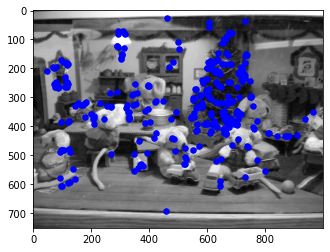

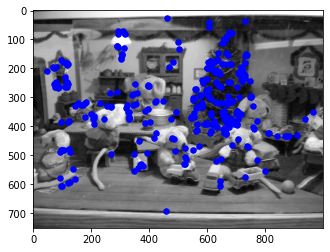

In [9]:
# utils.plot_points(im1, coords1)
utils.plot_points(im2, coords2)

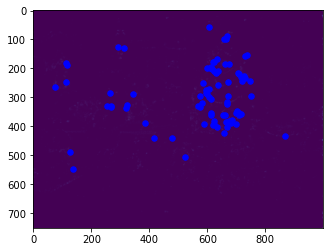

In [28]:
fig = utils.plot_points(im2, coords2)
plt.imshow(strength2)

# ANMS

In [41]:
corners1 = detector.anms(strength1, coords1)
# corners2 = detector.anms_2(strength2, coords2)
# assert len(corners1) == constants.NUM_KEEP, len(corners1)
# assert len(corners2) == constants.NUM_KEEP, len(corners2)
# print(f"Selected top {constants.NUM_KEEP} points from image 1.")
# print(f"Selected top {constants.NUM_KEEP} points from image 2.")

[566 266] <class 'numpy.ndarray'>
[963 494] <class 'numpy.ndarray'>
inputs:  (1, 2) (2086, 2)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
1
[466 605]
2
[570 540]
3
[622 369]


SystemExit: 

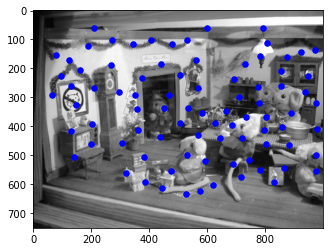

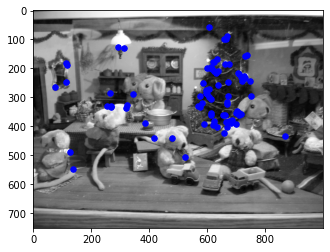

In [15]:
fig = utils.plot_points(im1, corners1)
fig = utils.plot_points(im2, corners2)

# CORNER DESCRIPTION

In [16]:
patches1 = descriptor.get_patches(im1, corners1)
vectors1 = np.stack([p.flatten() for p in patches1])
print(f"Computed descriptors of image 1.")

Computed descriptors of image 1.


In [17]:
patches2 = descriptor.get_patches(im2, corners2)
vectors2 = np.stack([p.flatten() for p in patches2])
print(f"Computed descriptors of image 2.")

Computed descriptors of image 2.


# CORNER MATCHING

In [23]:
matched1, matched2 = matching.match_features(corners1, vectors1, corners2, vectors2)
print(f"Found {len(matched1)}-{len(matched2)} candidate coorespondences.")

Found 2-2 candidate coorespondences.


In [25]:
if len(matched1) < 4:
    print(f"Cannot stitch images.")

Cannot stitch images.


In [26]:
result1, result2 = matching.ransac(matched1, matched2)

AssertionError: (0,)

In [ ]:
h2, corners2 = detector.get_corners(im2)
len(corners2)

In [ ]:
utils.plot_corners(im2, np.array([c.coord for c in corners2]))

# Do Adaptive Non-Maximal Suppression

In [ ]:
tmp = anms(corners1)

# Match Features

In [42]:
patches1 = get_patches(im1, corners1)
patches2 = get_patches(im2, corners2)

In [88]:
features1 = [Feature(c, p) for c, p in zip(corners1, patches1)]
features2 = [Feature(c, p) for c, p in zip(corners2, patches2)]

In [98]:
combos = np.array(list(itertools.product(features1, features2)))
combos.shape

(917715, 2)

In [99]:
dist2(patches1, patches2)

ValueError: too many values to unpack (expected 2)

In [100]:
patches1.shape

(951, 8, 8)

In [108]:
c1 = corners1
c2 = corners2
ndata, dimx = c1.shape #num_points1, dim1
ncenters, dimc = c2.shape #num_points2, dim2

In [109]:
np.ones((ncenters, 1)).shape

(965, 1)

In [107]:
np.sum((x ** 2).T, axis=0).shape

(951,)

In [111]:
a = (np.ones((ncenters, 1)) * np.sum((x ** 2).T, axis=0)).T
a.shape

(951, 965)

In [114]:
b = np.ones((ndata, 1)) * np.sum((c ** 2).T, axis=0)
b.shape

(951, 965)

In [9]:
a = np.array([1,2,3,4,1,2,3,4,1,2,3,4])
a = np.reshape(a, (3, 4))
a

array([[1, 2, 3, 4],
       [1, 2, 3, 4],
       [1, 2, 3, 4]])

In [11]:
a[:, ::3]

array([[1, 4],
       [1, 4],
       [1, 4]])

In [12]:
corners1[0]

array([  25, 1320])

In [14]:
im1[25, 1320]

array([0.92044222, 0.74115697, 0.42926749])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(8, 8, 3)

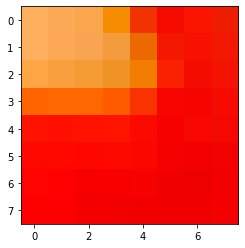

In [31]:
r, c = 25, 1320
patch = im1[r - 20 : r + 20, c - 20 : c + 20]
patch = skimage.transform.resize(patch, (8, 8))
patch = normalize(patch)
plt.imshow(patch)
patch.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(8, 8, 3)

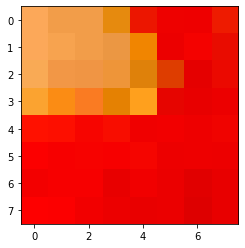

In [30]:
r, c = 25, 1320
patch = im1[r - 20 : r + 20, c - 20 : c + 20]
patch = patch[::5, ::5, :]
patch = normalize(patch)
plt.imshow(patch)
patch.shape

In [41]:
a = [1, 2, 3, 4]

In [42]:
a.remove(1z)

In [43]:
a

[2, 3, 4]